In [1]:
import os
import torch
import torchvision
import tarfile
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torch.utils.data import random_split
from torchvision.utils import make_grid
import matplotlib
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import glob
import torch.optim as optim
import time
from torchvision import transforms as T, models


import cv2
%matplotlib inline

In [2]:
data_dir = 'Archive/EuroSAT/'
print(os.listdir(data_dir))

['Forest', 'River', '.DS_Store', 'Highway', 'AnnualCrop', 'SeaLake', 'HerbaceousVegetation', 'Industrial', 'Residential', 'PermanentCrop', 'Pasture']


In [3]:
file_list = glob.glob(data_dir+"*")
for class_path in file_list:
    class_name = class_path.split("/")[-1]
    print(class_name)

Forest
River
Highway
AnnualCrop
SeaLake
HerbaceousVegetation
Industrial
Residential
PermanentCrop
Pasture


In [4]:
class CustomDataset(Dataset):
    def __init__(self,path,image_size):
        self.imgs_path = path
        file_list = glob.glob(self.imgs_path + "*")
        print(file_list)
        self.data = []
        for class_path in file_list:
            class_name = class_path.split("/")[-1]
            for img_path in glob.glob(class_path + "/*.jpg"):
                self.data.append([img_path, class_name])
        print(self.data)
        self.class_map = {"AnnualCrop" : 0, "Forest": 1,"HerbaceousVegetation": 2,"Highway": 3,"Industrial":4,"Pasture":5,"PermanentCrop":6,"Residential":7,"River":8,"SeaLake":9}
        self.img_dim = image_size
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        img_path, class_name = self.data[idx]
        img = cv2.imread(img_path)
        img = cv2.resize(img, self.img_dim)
        class_id = self.class_map[class_name]
        transform = transforms.Compose([transforms.ToTensor()])
        img_tensor = transform(img)
        mean, std, var = torch.mean(img_tensor), torch.std(img_tensor), torch.var(img_tensor)
        img_tensor = (img_tensor-mean)/std
        class_id = torch.tensor([class_id])
        return img_tensor, class_id

In [5]:
from torch.utils.data.sampler import SubsetRandomSampler

def load_data(path, test_split, val_split, batch_size, input_size, shuffle_dataset=True,random_seed=42):
    dataset = CustomDataset(path,input_size)	
    # Creating data indices for training and test splits:
    dataset_size = len(dataset)
    train_test_indices = list(range(dataset_size))
    test_split = int(np.floor(test_split * dataset_size))
    if shuffle_dataset :
        np.random.seed(random_seed)
        np.random.shuffle(train_test_indices)
    train_indices, test_indices = train_test_indices[test_split:], train_test_indices[:test_split]


   # Creating data indices for training and validation splits:
   
    train_data_size=len(train_indices)
    train_val_indices = list(range(train_data_size))
    val_split = int(np.floor(val_split * train_data_size))
    if shuffle_dataset :
        np.random.seed(random_seed)
        np.random.shuffle(train_val_indices)
    train_indices, val_indices = train_val_indices[val_split:], train_val_indices[:val_split]



    # Creating PT data samplers and loaders:
    train_sampler = SubsetRandomSampler(train_indices)
    test_sampler = SubsetRandomSampler(test_indices)
    val_sampler = SubsetRandomSampler(val_indices)

    data_loader_train = torch.utils.data.DataLoader(dataset, batch_size=batch_size, 
                                              sampler=train_sampler)
    data_loader_test = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                                    sampler=test_sampler)

    data_loader_val = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                                    sampler=val_sampler)


   
    print(len(data_loader_train),len(data_loader_test),len(data_loader_val))
    
    return data_loader_train, data_loader_test, data_loader_val

In [6]:
data_loader_train, data_loader_test, data_loader_val=load_data(data_dir,.2,.2,32,(64,64))

print(len(data_loader_val))

['Archive/EuroSAT/Forest', 'Archive/EuroSAT/River', 'Archive/EuroSAT/Highway', 'Archive/EuroSAT/AnnualCrop', 'Archive/EuroSAT/SeaLake', 'Archive/EuroSAT/HerbaceousVegetation', 'Archive/EuroSAT/Industrial', 'Archive/EuroSAT/Residential', 'Archive/EuroSAT/PermanentCrop', 'Archive/EuroSAT/Pasture']
[['Archive/EuroSAT/Forest/Forest_864.jpg', 'Forest'], ['Archive/EuroSAT/Forest/Forest_2917.jpg', 'Forest'], ['Archive/EuroSAT/Forest/Forest_2903.jpg', 'Forest'], ['Archive/EuroSAT/Forest/Forest_870.jpg', 'Forest'], ['Archive/EuroSAT/Forest/Forest_680.jpg', 'Forest'], ['Archive/EuroSAT/Forest/Forest_858.jpg', 'Forest'], ['Archive/EuroSAT/Forest/Forest_2095.jpg', 'Forest'], ['Archive/EuroSAT/Forest/Forest_2081.jpg', 'Forest'], ['Archive/EuroSAT/Forest/Forest_1588.jpg', 'Forest'], ['Archive/EuroSAT/Forest/Forest_694.jpg', 'Forest'], ['Archive/EuroSAT/Forest/Forest_1205.jpg', 'Forest'], ['Archive/EuroSAT/Forest/Forest_119.jpg', 'Forest'], ['Archive/EuroSAT/Forest/Forest_1563.jpg', 'Forest'], ['Arch

In [7]:
def plot_data_loader(data_loader, gridDims):
    fig, axes = plt.subplots(nrows=gridDims[0], ncols=gridDims[1], figsize=(5,5))
    dataiter = iter(data_loader)
    for i in range(gridDims[0]):
        for j in range(gridDims[1]):
            images, _ = next(dataiter)
            axes[i, j].imshow(np.transpose(images[0].numpy(), (1, 2, 0)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


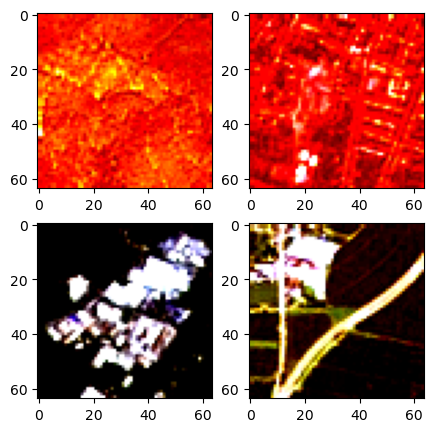

In [8]:
plot_data_loader(data_loader_test,[2,2])

In [9]:
 model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)


In [10]:
d = "cpu"
if torch.backends.mps.is_available() and torch.backends.mps.is_built():
    d = "mps"
elif torch.cuda.is_available():
    d = "cuda:0"
device = torch.device(d)

print("Device: {}".format(device))

Device: mps


In [11]:
import torch
import torch.backends.cudnn as cudnn
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models

import argparse
import os

import numpy as np
import pandas as pd
# from tsne import bh_sne
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt

In [12]:
#TSNE
sat_map ={0:"AnnualCrop", 1:"Forest",2:"HerbaceousVegetation",3:"Highway",4:"Industrial",5:"Pasture",6:"PermanentCrop",7:"Residential",8:"River",9:"SeaLake"}


model.to(device)

model.eval()
targets_list = []
outputs_list = []

with torch.no_grad():
    for idx, (inputs, targets) in enumerate(data_loader_train):
        inputs = inputs.to(device)
        targets = targets.to(device)
        targets_np = targets.data.cpu().numpy()

        outputs = model(inputs)
        outputs_np = outputs.data.cpu().numpy()

        targets_list.append(targets_np)
        outputs_list.append(outputs_np)

targets = np.concatenate(targets_list, axis=0)
outputs = np.concatenate(outputs_list, axis=0).astype(np.float64)

generating t-SNE plot...


/Users/priyangpatel/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/priyangpatel/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/var/folders/mz/c6q_6p393sq4xcqpm9k620p00000gn/T/ipykernel_12186/3887831682.py:18: UserWarning: The palette list has more values (10) than needed (8), which may not be intended.
  sns.scatterplot(


done!


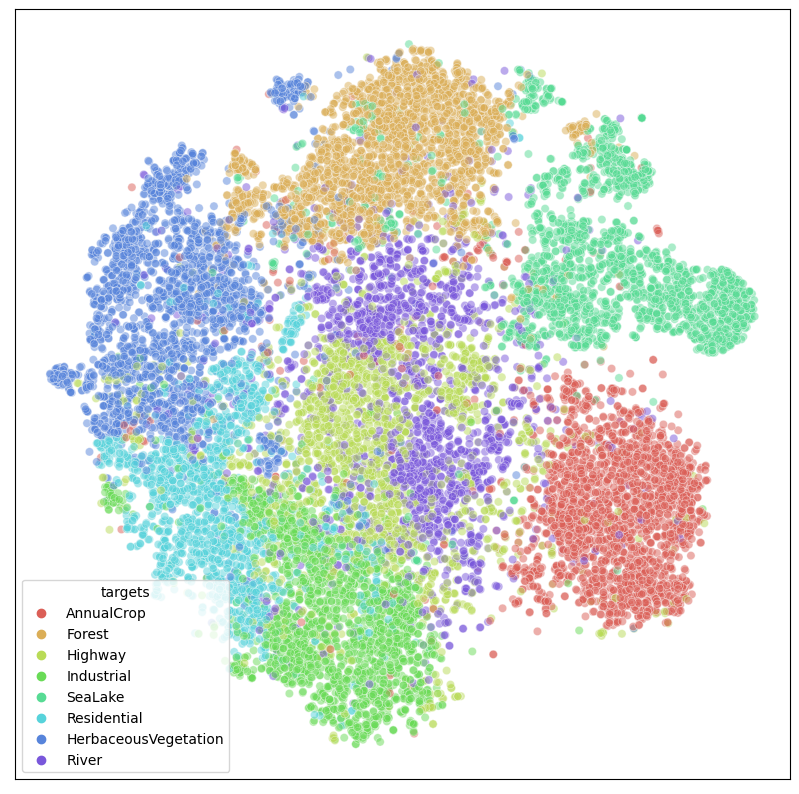

In [13]:
import pandas as pd
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt
print('generating t-SNE plot...')


tsne = TSNE(random_state=0)
tsne_output = tsne.fit_transform(outputs)

df = pd.DataFrame(tsne_output, columns=['x', 'y'])
df.insert(2, "targets", targets, True)
df.loc[:, 'targets'] = df.targets.map(sat_map)


plt.rcParams['figure.figsize'] = 10, 10

sns.scatterplot(
        x='x', y='y',
        hue='targets',
        palette=sns.color_palette("hls", 10),
        data=df,
        marker='o',
        legend="full",
        alpha=0.5
)

plt.xticks([])
plt.yticks([])
plt.xlabel('')
plt.ylabel('')

print('done!')



In [18]:
optimizer = optim.Adam(model.parameters(),lr=0.001);
criterion = nn.CrossEntropyLoss()


In [19]:
d = "cpu"
if torch.backends.mps.is_available() and torch.backends.mps.is_built():
    d = "mps"
elif torch.cuda.is_available():
    d = "cuda:0"
device = torch.device(d)

print("Device: {}".format(device))

Device: mps


In [20]:
model.to(device)

num_epochs = 30
total_steps = len(data_loader_train)
t1 = time.time()
accuracies = []
losses = []

for epoch in range(num_epochs):
    ti = 0;
    total_correct = 0;
    tl = 0.0;
    for i, data in enumerate(data_loader_train):
        images, labels = data[0].to(device), data[1].to(device)
        labels=torch.flatten(labels)
        outputs = model(images)
        loss = criterion(outputs, labels)
        tl+=loss.item()
        # Backprop and optimisation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Train accuracy
        total = labels.size(0)
        ti+=total
        _,predicted = torch.max(outputs.data, 1)
        correct = (predicted == labels).sum().item()
        total_correct+= (predicted == labels).sum()
        if (i + 1) % 100 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
                  .format(epoch + 1, num_epochs, i + 1, total_steps, loss.item(),
                      (correct / total) * 100))
    accuracies.append(total_correct/ti*100.0)
    losses.append(float(tl)/ti)
           
print("######## Training Finished in {} seconds ###########".format(time.time()-t1))

Epoch [1/30], Step [100/540], Loss: 0.3792, Accuracy: 87.50%
Epoch [1/30], Step [200/540], Loss: 0.5280, Accuracy: 81.25%
Epoch [1/30], Step [300/540], Loss: 0.5399, Accuracy: 84.38%
Epoch [1/30], Step [400/540], Loss: 0.2926, Accuracy: 93.75%
Epoch [1/30], Step [500/540], Loss: 0.4278, Accuracy: 84.38%
Epoch [2/30], Step [100/540], Loss: 0.2656, Accuracy: 90.62%
Epoch [2/30], Step [200/540], Loss: 1.1753, Accuracy: 81.25%
Epoch [2/30], Step [300/540], Loss: 0.3349, Accuracy: 93.75%
Epoch [2/30], Step [400/540], Loss: 0.5559, Accuracy: 84.38%
Epoch [2/30], Step [500/540], Loss: 0.3532, Accuracy: 87.50%
Epoch [3/30], Step [100/540], Loss: 0.0571, Accuracy: 100.00%
Epoch [3/30], Step [200/540], Loss: 0.3032, Accuracy: 93.75%
Epoch [3/30], Step [300/540], Loss: 0.1171, Accuracy: 96.88%
Epoch [3/30], Step [400/540], Loss: 0.1927, Accuracy: 90.62%
Epoch [3/30], Step [500/540], Loss: 0.6006, Accuracy: 81.25%
Epoch [4/30], Step [100/540], Loss: 0.7127, Accuracy: 75.00%
Epoch [4/30], Step [200

Epoch [27/30], Step [300/540], Loss: 0.0044, Accuracy: 100.00%
Epoch [27/30], Step [400/540], Loss: 0.0040, Accuracy: 100.00%
Epoch [27/30], Step [500/540], Loss: 0.0015, Accuracy: 100.00%
Epoch [28/30], Step [100/540], Loss: 0.1204, Accuracy: 96.88%
Epoch [28/30], Step [200/540], Loss: 0.1153, Accuracy: 96.88%
Epoch [28/30], Step [300/540], Loss: 0.0061, Accuracy: 100.00%
Epoch [28/30], Step [400/540], Loss: 0.0075, Accuracy: 100.00%
Epoch [28/30], Step [500/540], Loss: 0.0109, Accuracy: 100.00%
Epoch [29/30], Step [100/540], Loss: 0.0098, Accuracy: 100.00%
Epoch [29/30], Step [200/540], Loss: 0.0367, Accuracy: 96.88%
Epoch [29/30], Step [300/540], Loss: 0.0121, Accuracy: 100.00%
Epoch [29/30], Step [400/540], Loss: 0.0054, Accuracy: 100.00%
Epoch [29/30], Step [500/540], Loss: 0.0231, Accuracy: 96.88%
Epoch [30/30], Step [100/540], Loss: 0.0001, Accuracy: 100.00%
Epoch [30/30], Step [200/540], Loss: 0.0125, Accuracy: 100.00%
Epoch [30/30], Step [300/540], Loss: 0.0032, Accuracy: 100.

In [21]:
model.eval() 
with torch.no_grad(): 
 correct = 0
 total = 0
 for data in data_loader_test:
  images, labels = data[0].to(device), data[1].to(device)
  labels=torch.flatten(labels)
  outputs = model(images)
  _, predicted = torch.max(outputs.data, 1)
  total += labels.size(0)
  correct += (predicted == labels).sum().item()
print('Test Accuracy of the model on the {} test images: {} %'
  .format(total, (correct / total) * 100))

Test Accuracy of the model on the 5400 test images: 81.18518518518518 %


In [22]:
acc_list = [i.item() for i in accuracies]

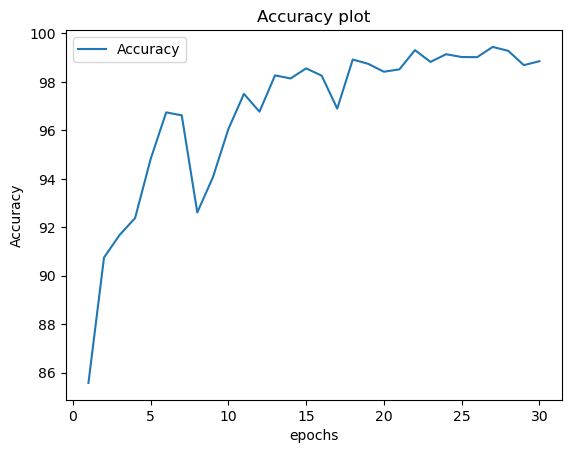

In [23]:
plt.figure()
plt.xlabel('epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy plot')
plt.plot(range(1,num_epochs+1),acc_list)
plt.legend(['Accuracy'])

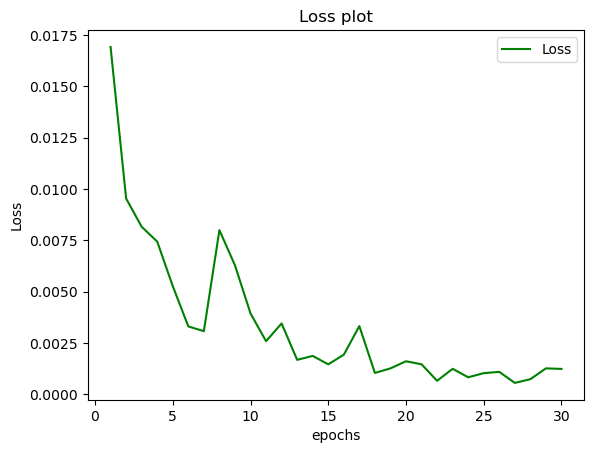

In [24]:
plt.figure()
plt.xlabel('epochs')
plt.ylabel('Loss')
plt.title('Loss plot')
plt.plot(range(1,num_epochs+1),losses,'g')
plt.legend(['Loss'])